This notebook compares various models using the following methology:
1. Firstly a sample of 1/3 of all the NDAs are randomly selected
2. This sample size is then reduced to just the NDA with both additions and related patents, since NDAs without either cannot produce meaningful results.
3. With approximately 300 NDA number, for each NDA:
*   A setid for that NDA with the longest additions history is then selected.
*   All additions for the set-id are grouped together in a list
*   All patents claim related to that set-id are grouped together in a list
*   A random patent with claims for another NDA unrelated to the NDA is selected and all patent claims are grouped in a list
*   The highest similarity scores for each addition to related patent claim is then average together (Related Value).
*   The highest similarity scores for each addition to unrelated patent claim is then averaged together (Noise Value).
*   These average values are collected into a Related list and Unrelated/Noise list so that their distributions can be plotted.

Step 3 is performed repeatedly for multiple models with multiple parameters to test if there is a best model that has a Related distribution furthest away from the noise distribution.


In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
zip_path='/content/drive/MyDrive/Colab Notebooks/zip/db2file.zip'
!cp "{zip_path}" .
!cp "/content/drive/MyDrive/Colab Notebooks/requirements.txt" .
!unzip -q db2file.zip
!rm db2file.zip
!rm -r en_core_sci_lg-0.4.0.zip
!cp "/content/drive/MyDrive/Colab Notebooks/zip/en_core_sci_lg-0.4.0.zip" .
!unzip -q en_core_sci_lg-0.4.0.zip
!rm en_core_sci_lg-0.4.0.zip

Mounted at /content/drive
rm: cannot remove 'en_core_sci_lg-0.4.0.zip': No such file or directory


In [2]:
!pip install -r '/content/requirements.txt'

     |████████████████████████████████| 122kB 2.8MB/s 
     |████████████████████████████████| 9.8MB 11.4MB/s 
     |████████████████████████████████| 184kB 43.0MB/s 
     |████████████████████████████████| 71kB 7.8MB/s 
     |████████████████████████████████| 71kB 7.8MB/s 
     |████████████████████████████████| 6.3MB 40.0MB/s 
     |████████████████████████████████| 1.5MB 24.3MB/s 
     |████████████████████████████████| 13.5MB 46.3MB/s 
     |████████████████████████████████| 15.3MB 137kB/s 
     |████████████████████████████████| 9.9MB 52.8MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 296kB 39.0MB/s 
     |████████████████████████████████| 194kB 43.4MB/s 
     |████████████████████████████████| 9.1MB 44.1MB/s 
     |████████████████████████████████| 71kB 9.0MB/s 
     |████████████████████████████████| 512kB 47.1MB/s 
     |████████████████████████████████| 727kB 45.6MB/s 
     |████████████████████████████████| 61kB 7.0MB/s 
  

In [3]:
import random
import os
random.seed(20)
db2files = "/content/db2file/"
NDA_list=[f for f in os.listdir(db2files)]
random_NDA_list=random.sample(NDA_list, int(len(NDA_list)*.33))

In [4]:
def get_lines_in_file(file_name):
  if os.path.exists(file_name):
    f = open(file_name, "rb")
    return_list = [str(line.decode('unicode_escape')) for line in f if line.decode('unicode_escape').strip()]
    f.close()
    return return_list
  else:
    return []

In [5]:
def flat_list(lst):
  return [item for sublist in lst for item in sublist]

def get_additions(NDA, additions_folder_name):
  """ 
  Return all additions as a list for the set-id with most additions for a NDA 
  excluding the first addition.
  Parameters:
      NDA (string): NDA dir
      additions_folder_name (string): either 'just_additions' or 'additions_with_context'
  """
  if additions_folder_name not in ['just_additions', 'additions_with_context']:
    print(f"Parameter {additions_folder_name} not in ['just_additions', 'additions_with_context']")
    return []
  NDA_dir=db2files+str(NDA)+'/'
  set_id_dirs=[f for f in os.listdir(NDA_dir)]
  try:
    set_id_dirs.remove('patents')
  except ValueError:
    pass
  additions_list=[]
  for set_id_dir in set_id_dirs:
    additions_dir=NDA_dir+set_id_dir+'/'+additions_folder_name+'/'
    if os.path.exists(additions_dir):
      additions_files=sorted([additions_dir+f for f in os.listdir(additions_dir)])[1:]
      additions_list_tmp=flat_list([get_lines_in_file(file) for file in additions_files])
      if len(additions_list_tmp)> len(additions_list):
        additions_list=additions_list_tmp
  return additions_list

def get_patent_claims(NDA, patents_folder_name):
  """Return a list of patents claims for a NDA
  Parameters:
      NDA (string): NDA dir
      patents_folder_name (string): either 'patents' or 'patents_longhand'
  """
  patent_dir=db2files+str(NDA)+'/'+patents_folder_name+'/'
  if os.path.exists(patent_dir):
    patent_files=[patent_dir+f for f in os.listdir(patent_dir)]
    return flat_list([get_lines_in_file(file) for file in patent_files])
  return []
    

In [6]:
# print(get_lines_in_file(db2files+'15923/patents/3438991'))
# print(get_additions(15923, 'just_additions'))
# print(len(get_additions(15923, 'just_additions')))
# print(get_patent_claims(10402, "patents"))
print(len(NDA_list), len(random_NDA_list), random_NDA_list[1])

1606 529 206679


In [7]:

# narrow 1/3 of random data to NDA with patents and NDAs with additions.  If either is missing, we cannot check quality of additions to related patents.
random_NDA_list=[x for x in random_NDA_list if get_patent_claims(x, 'patents') and get_additions(x, 'additions_with_context')]


In [8]:
print(len(random_NDA_list))


311


In [9]:
def calculate_score(random_NDA_list, additions_folder_name, patent_folder_name, scoring_method, optional_scoring_method_field=None, silent=False):
  """
  This method take a scoring_method and returns (bad_average_of_best_scores_list, good_average_of_best_scores_list)
  Parameters:
    random_NDA_list (list): list of NDA numbers
    additions_folder_name (string): either 'patents' or 'patents_longhand'
    patent_folder_name (string): either 'just_additions' or 'additions_with_context'
    scoring_method (function): function that is use to score similarity
  """
  bad_average_of_best_scores_list=[]
  good_average_of_best_scores_list=[]

  for i in range(len(random_NDA_list)):
    if not silent:
      print(f"processing {str(i)} of {str(len(random_NDA_list))}")
    NDA=random_NDA_list[i]

    # choose a bad_NDA (not the current NDA) with patent claims
    bad_NDA = None
    while not bad_NDA:
      new_random_NDA=random.sample(NDA_list, 1)[0]
      if new_random_NDA==NDA:
        continue
      elif get_patent_claims(new_random_NDA, patent_folder_name):
        bad_NDA=new_random_NDA
  
    claims_bad = get_patent_claims(bad_NDA, patent_folder_name)
    claims_good = get_patent_claims(NDA, patent_folder_name)
    additions = get_additions(NDA, additions_folder_name)

    # get average of best similarity scores for patent claims to additions bad_NDA
    bad_average_of_best_scores_list.append(mean(scoring_method(additions, claims_bad, optional_scoring_method_field)))
    # get average of best similarity scores for patent claim for method
    good_average_of_best_scores_list.append(mean(scoring_method(additions, claims_good, optional_scoring_method_field)))

  return bad_average_of_best_scores_list, good_average_of_best_scores_list

def mean(lst):
  return sum(lst)/len(lst)

def std_dev(lst):
  variance = sum([((x - mean(lst)) ** 2) for x in lst]) / len(lst)
  return variance ** 0.5



In [10]:
from sentence_transformers import SentenceTransformer, util

def scoring_method_bert(additions, claims, model):
  """ Returns a list of highest scores for 
  """
  # Compute embedding for both lists
  additions_embeddings = model.encode(
      additions,
      convert_to_tensor=True,
  )
  claims_embeddings = model.encode(
      claims,
      convert_to_tensor=True,
  )
  # Compute cosine-similarity for every additions to every claim
  cosine_scores = util.pytorch_cos_sim(
      additions_embeddings, claims_embeddings
  ).tolist()
  # return the highest similarity score for each section to patent claim
  return [max(x) for x in cosine_scores]

In [11]:
import matplotlib.pyplot as plt

def plot(score_list_set, model, method="Cosine Similarity"):
  plt.subplot(1,2,1)
  plt.hist(score_list_set[0], color="blue", edgecolor="black", bins=int(180/5))
  plt.title(f"Histogram of {method} of Additions to Unrelated Claims (Blue) Versus Related Claims (Green)\n For {model}")
  plt.xlabel('score')
  plt.subplot(1,2,2)
  plt.hist(score_list_set[1], color="green", edgecolor="black", bins=int(180/5))
  plt.xlabel('score')
  plt.show()

def print_mean_std_dev(score_list_set):
  print(f"mean noise: {mean(score_list_set[0])}")
  print(f"std_dev noise: {std_dev(score_list_set[0])}")
  print(f"mean related: {mean(score_list_set[1])}")
  print(f"std_dev related: {std_dev(score_list_set[1])}")

def print_mean_std_dev(score_list_set, plot=plot):
  print(f"mean noise: {mean(score_list_set[0])}")
  print(f"std_dev noise: {std_dev(score_list_set[0])}")
  print(f"mean related: {mean(score_list_set[1])}")
  print(f"std_dev related: {std_dev(score_list_set[1])}")

import scipy.stats

def print_z_score(score_list_set):
  """ 
  Print Z score which is number of standard deviations (wherein distribution is 
  centered at 0) of the means of the additions to related patent is to the mean 
  of additions to unrelated patent.
  z=(x-u)/s; where x is the mean of additions to related patents, and u is means 
  of additions to unrelated patents, and x is standard deviation of additions to 
  unrelated patents.
  p(-z) is the probability that is it better than noise
  """
  z_score=(mean(score_list_set[1])-mean(score_list_set[0]))/std_dev(score_list_set[0])
  print(f"z_score: {z_score}")
  print(f"p(-z): {scipy.stats.norm.sf(z_score*-1)}")

def plot_print(score_list_set, model, method="Cosine Similarity", plot_=plot):
  plot_(score_list_set, model, method="Cosine Similarity")
  print_mean_std_dev(score_list_set)
  print_z_score(score_list_set)

_device=None

In [ ]:
# distilroberta_with_context is a set of (bad average of best similarity scores list, good average of best similarity scores list)
_device = None
model_distilroberta = SentenceTransformer("stsb-distilroberta-base-v2", device=_device)
model_distilroberta.max_seq_length=512
distilroberta_additions_with_context_patents=calculate_score(random_NDA_list, "additions_with_context", "patents", scoring_method_bert, model_distilroberta, silent=True)

  0%|          | 0.00/305M [00:00<?, ?B/s]

In [ ]:
distilroberta_just_additions_patents=calculate_score(random_NDA_list, "just_additions", "patents", scoring_method_bert, model_distilroberta, silent=True)

In [ ]:
distilroberta_additions_with_context_patents_longhand=calculate_score(random_NDA_list, "additions_with_context", "patents_longhand", scoring_method_bert, model_distilroberta, silent=True)
model_distilroberta.zero_grad()

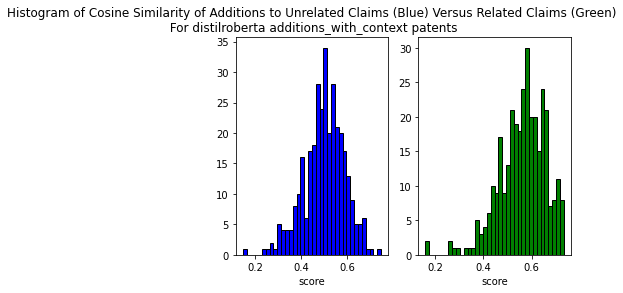

mean noise: 0.5004733486838759
std_dev noise: 0.08934526989761629
mean related: 0.5607847069655073
std_dev related: 0.09567025792291695
z_score: 0.675036947683343
p(-z): 0.7501738544484114


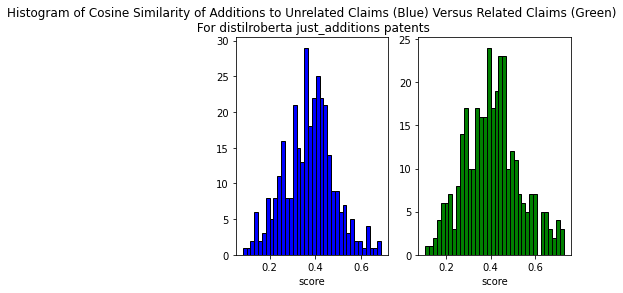

mean noise: 0.3716139454943803
std_dev noise: 0.10965992463432835
mean related: 0.4068881264547623
std_dev related: 0.12442657411102401
z_score: 0.3216688419037963
p(-z): 0.6261482075867304


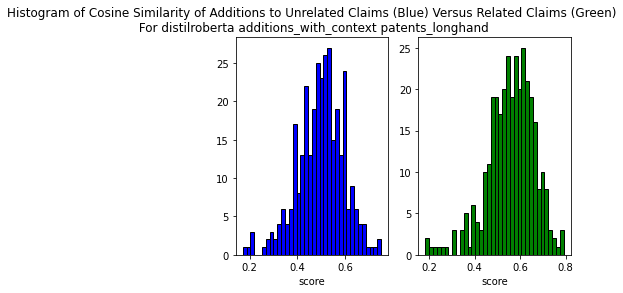

mean noise: 0.49805954747556075
std_dev noise: 0.09670328486955583
mean related: 0.5581885474989585
std_dev related: 0.10342180240966864
z_score: 0.6217885990585167
p(-z): 0.732959558003027


In [ ]:
plot_print(distilroberta_additions_with_context_patents, "distilroberta additions_with_context patents")
plot_print(distilroberta_just_additions_patents, "distilroberta just_additions patents")
plot_print(distilroberta_additions_with_context_patents_longhand, "distilroberta additions_with_context patents_longhand")

In [ ]:
model_scibert_uncased = SentenceTransformer("allenai/scibert_scivocab_uncased", device=_device)
model_scibert_uncased.max_seq_length=512
scibert_uncased=calculate_score(random_NDA_list, "additions_with_context", "patents", scoring_method_bert, model_scibert_uncased, silent=True)
model_scibert_uncased.zero_grad()

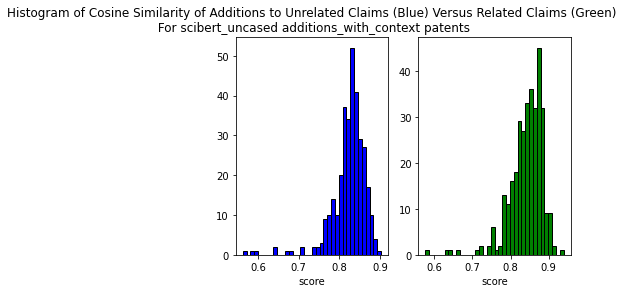

mean noise: 0.8231999282974127
std_dev noise: 0.042995305679390125
mean related: 0.8419258896454255
std_dev related: 0.043767350022005144
z_score: 0.4355350206752703
p(-z): 0.6684129376186183


In [ ]:
plot_print(scibert_uncased, "scibert_uncased additions_with_context patents")

Exception when trying to download http://sbert.net/models/allenai/longformer-base-4096.zip. Response 404
SentenceTransformer-Model http://sbert.net/models/allenai/longformer-base-4096.zip not found. Try to create it from scratch
Try to create Transformer Model allenai/longformer-base-4096 with mean pooling


Downloading:   0%|          | 0.00/694 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/597M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

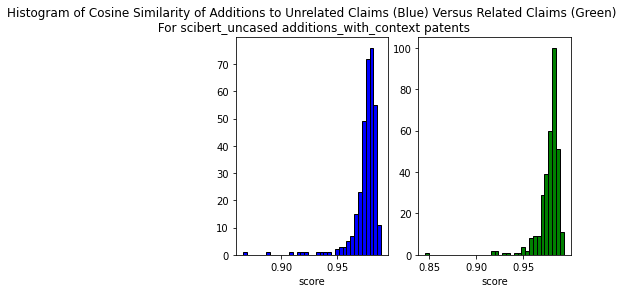

mean noise: 0.9750181277683894
std_dev noise: 0.012870070837641715
mean related: 0.976726786080129
std_dev related: 0.01313463779470629
z_score: 0.13276215285017803
p(-z): 0.5528092565092222


In [ ]:
model_longformer = SentenceTransformer("allenai/longformer-base-4096", device=_device)
model_longformer.zero_grad()
# Will limit size since CUDA runs out of memory
model_longformer.max_seq_length=1024
longformer=calculate_score(random_NDA_list, "additions_with_context", "patents", scoring_method_bert, model_longformer, silent=True)
model_longformer.zero_grad()
plot_print(longformer, "scibert_uncased additions_with_context patents")

Exception when trying to download http://sbert.net/models/dmis-lab/biobert-v1.1.zip. Response 404
SentenceTransformer-Model http://sbert.net/models/dmis-lab/biobert-v1.1.zip not found. Try to create it from scratch
Try to create Transformer Model dmis-lab/biobert-v1.1 with mean pooling


Downloading:   0%|          | 0.00/462 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

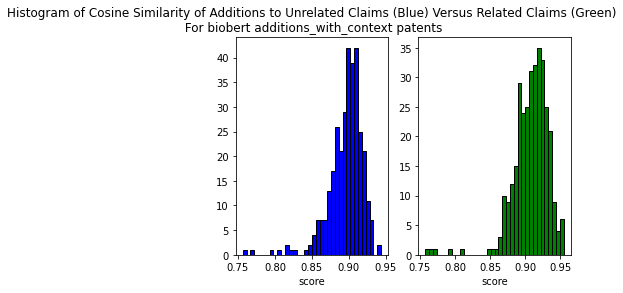

mean noise: 0.895509648809786
std_dev noise: 0.023633738224793546
mean related: 0.9074018180359154
std_dev related: 0.025882182529893112
z_score: 0.5031861279420272
p(-z): 0.6925832915377483


In [ ]:
model_biobert = SentenceTransformer("dmis-lab/biobert-v1.1", device=_device)
model_biobert.zero_grad()
# Will limit size since CUDA runs out of memory
model_longformer.max_seq_length=512
biobert=calculate_score(random_NDA_list, "additions_with_context", "patents", scoring_method_bert, model_biobert, silent=True)
model_biobert.zero_grad()
plot_print(biobert, "biobert additions_with_context patents")

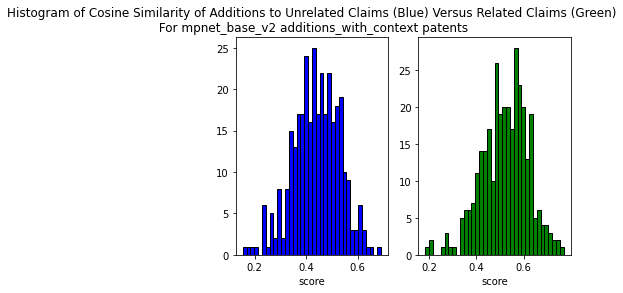

mean noise: 0.4379976573072343
std_dev noise: 0.09040082803374878
mean related: 0.5194639898788157
std_dev related: 0.09819081536804886
z_score: 0.9011679908636246
p(-z): 0.8162504964332901


In [ ]:
model_mpnet_base_v2 = SentenceTransformer("stsb-mpnet-base-v2", device=_device)
model_mpnet_base_v2.zero_grad()
# Will limit size since CUDA runs out of memory
model_mpnet_base_v2.max_seq_length=512
mpnet_base_v2=calculate_score(random_NDA_list, "additions_with_context", "patents", scoring_method_bert, model_mpnet_base_v2, silent=True)
model_mpnet_base_v2.zero_grad()
plot_print(mpnet_base_v2, "mpnet_base_v2 additions_with_context patents")

  0%|          | 0.00/460M [00:00<?, ?B/s]

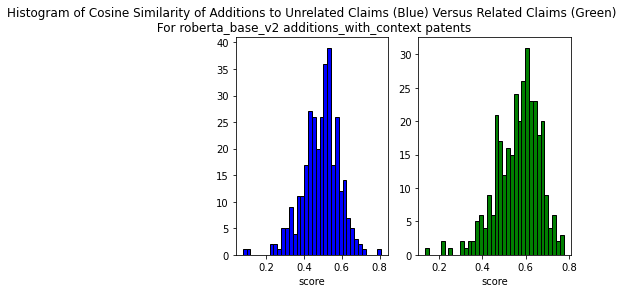

mean noise: 0.4885933166749539
std_dev noise: 0.09712029532671895
mean related: 0.5643114832822393
std_dev related: 0.10063484810581934
z_score: 0.7796327879004549
p(-z): 0.7821964745699855


In [ ]:
model_roberta_base_v2 = SentenceTransformer("stsb-roberta-base-v2", device=_device)
model_roberta_base_v2.zero_grad()
# Will limit size since CUDA runs out of memory
model_roberta_base_v2.max_seq_length=512
roberta_base_v2=calculate_score(random_NDA_list, "additions_with_context", "patents", scoring_method_bert, model_roberta_base_v2, silent=True)
model_roberta_base_v2.zero_grad()
plot_print(roberta_base_v2, "roberta_base_v2 additions_with_context patents")

In [ ]:
import spacy

_en_core_sci_lg_nlp = spacy.load("/content/en_core_sci_lg-0.4.0/en_core_sci_lg/en_core_sci_lg-0.4.0")
# set number of processes for nlp.pipe for spaCy
_N_PROCESS = 3

In [ ]:
def preprocess_with_spacy_nlp(text_list, steps, nlp=_en_core_sci_lg_nlp):
    """
    This method can remove punctuation,
    Parameters:
        text_list (list): list of strings
        steps (list): one of ["punct", "lemma", "stopwords"]
    """
    # make a copy of text_lis
    return_list = text_list
    if any(item in ["punct", "lemma", "stopwords"] for item in steps):
        # 'lemmatizer' required 'tagger' and 'attribute_ruler'
        nlp_list = list(
            nlp.pipe(
                return_list,
                disable=["tok2vec", "ner"],
                n_process=_N_PROCESS,
            )
        )
        return_list = [
            " ".join(
                [
                    token.lemma_ if "lemma" in steps else token.text
                    for token in doc
                    if (
                        (
                            ("punct" in steps and not token.is_punct)
                            or "punct" not in steps
                        )
                        and (
                            ("stopwords" in steps and not token.is_stop)
                            or "stopwords" not in steps
                        )
                    )
                ]
            )
            for doc in nlp_list
        ]
    return return_list


def similarity_matrix(embed_A_list, embed_B_list):
    """
    This method returns a matrix such as:
        [[X, X, X],
        [X, X, X]]
    wherein each row represents the similarity measurement between an embedding
    from embed_A_list to each of the embeddings in embed_B_list.

    Parameters:
        embed_A_list (list): list of NLP object generated by spaCy
        embed_B_list (list): list of NLP object generated by spaCy to be
                             compared to embed_A
    """
    matrix = [[0] * len(embed_B_list) for y in range(len(embed_A_list))]
    for i in range(len(embed_A_list)):
        for j in range(len(embed_B_list)):
            matrix[i][j] = embed_A_list[i].similarity(embed_B_list[j])
    return matrix


def scoring_method_spacy(additions, claims, nlp=_en_core_sci_lg_nlp):
  """ Scores with spaCy
  """
  additions=preprocess_with_spacy_nlp(additions, ["punct", "lemma", "stopwords"], nlp)
  claims=preprocess_with_spacy_nlp(claims, ["punct", "lemma", "stopwords"], nlp)
  # Compute embedding for both lists
  # tokenization only requires tok2vec
  disabled_list = ["tagger", "attribute_ruler", "lemmatizer", "parser", "ner"]
  additions_embeddings = list(
      nlp.pipe(
          additions, disable=disabled_list, n_process=_N_PROCESS
      )
  )
  claims_embeddings = list(
      nlp.pipe(
          claims, disable=disabled_list, n_process=_N_PROCESS
      )
  )
  # Compute cosine-similarity for every additions to every claim
  cosine_scores = similarity_matrix(additions_embeddings, claims_embeddings)
  # return the highest similarity score for each section to patent claim
  return [max(x) for x in cosine_scores]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.


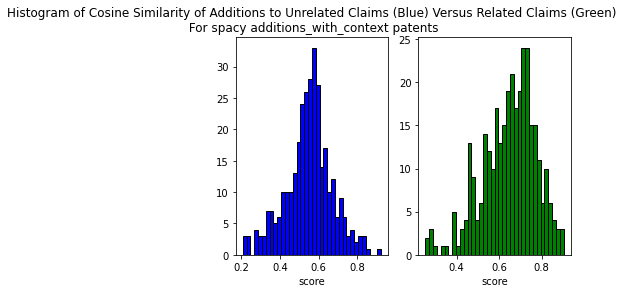

mean noise: 0.5462093602761117
std_dev noise: 0.12192011209500322
mean related: 0.6461000895553783
std_dev related: 0.125938847744988
z_score: 0.8193129711152931
p(-z): 0.7936960630465137


In [ ]:
spacy_sci=calculate_score(random_NDA_list, "additions_with_context", "patents", scoring_method_spacy, _en_core_sci_lg_nlp, silent=True)
plot_print(spacy_sci, "spacy additions_with_context patents")

In [ ]:
!python -m spacy download en_core_web_trf
nlp_en = spacy.load('en_core_web_trf')
spacy_en_just_additions=calculate_score(random_NDA_list, "just_additions", "patents", scoring_method_spacy, nlp_en, silent=True)
plot_print(spacy_en_just_additions, "spacy_en just_additions patents")

2021-05-05 17:28:37.472719: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
     |████████████████████████████████| 459.7MB 31kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')


2021-05-05 04:44:16.594459: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.


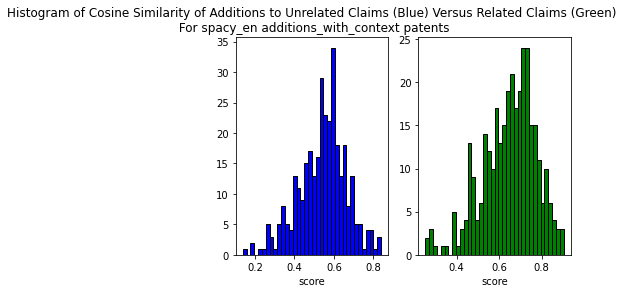

mean noise: 0.5406748139009613
std_dev noise: 0.12172848580239802
mean related: 0.6461000895553783
std_dev related: 0.125938847744988
z_score: 0.8660690631242552
p(-z): 0.8067738552879775


In [ ]:
spacy_en=calculate_score(random_NDA_list, "additions_with_context", "patents", scoring_method_spacy, nlp_en, silent=True)
plot_print(spacy_en, "spacy_en additions_with_context patents")

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
vectorizer = TfidfVectorizer()

def similarity_matrix_tfidf(embed_A, embed_B):
    """
    This method returns a matrix such as:
        [[X, X, X],
        [X, X, X]]
    wherein each row represents the similarity measurement between an embedding
    from embed_A to each of the embeddings in embed_B.

    Parameters:
        embed_A (ndarray): ndarray object generated by scikit-learn of shape
                           (n_samples, n_features)
        embed_B (ndarray): ndarray object generated by scikit-learn of shape
                           (n_samples, n_features) to be compared to embed_A
    """
    matrix = [[0] * embed_B.shape[0] for y in range(embed_A.shape[0])]
    for i in range(embed_A.shape[0]):
        for j in range(embed_B.shape[0]):
            matrix[i][j] = cosine_similarity(embed_A[i], embed_B[j]).item()
    return matrix

def scoring_method_tfidf(additions, claims, empty):
  """ Scores with tfidf
  """
  additions=preprocess_with_spacy_nlp(additions, ["punct", "lemma", "stopwords"])
  claims=preprocess_with_spacy_nlp(claims, ["punct", "lemma", "stopwords"])

  all_embeddings = vectorizer.fit_transform(additions + claims)
  additions_embeddings = all_embeddings[: len(additions)]
  claims_embeddings = all_embeddings[len(additions) :]

  # Compute cosine-similarity for every additions to every claim
  cosine_scores = similarity_matrix_tfidf(additions_embeddings, claims_embeddings)

  # return the highest similarity score for each section to patent claim
  return [max(x) for x in cosine_scores]


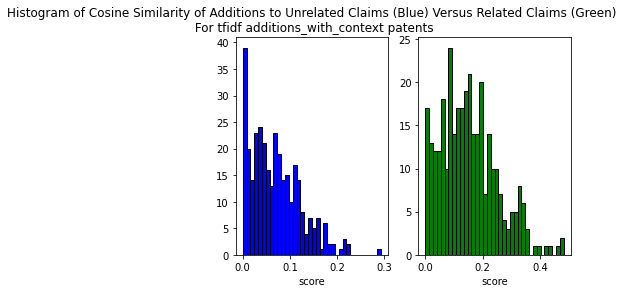

mean noise: 0.06916472691861368
std_dev noise: 0.05316396484580964
mean related: 0.15244918564885993
std_dev related: 0.09820197005072008
z_score: 1.5665584568757138
p(-z): 0.9413910326749335


In [ ]:
tfidf=calculate_score(random_NDA_list, "additions_with_context", "patents", scoring_method_tfidf, silent=True)
plot_print(tfidf, "tfidf additions_with_context patents")

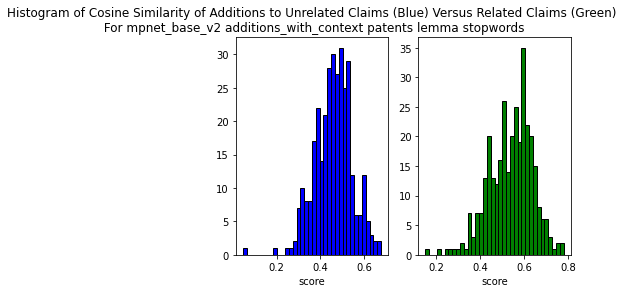

mean noise: 0.4594119418956195
std_dev noise: 0.08517038962857619
mean related: 0.5374017669302316
std_dev related: 0.09921972630182309
z_score: 0.9156917723955682
p(-z): 0.8200857092151411


In [ ]:
def scoring_method_bert_with_preprocessing(additions, claims, model):
  """ Returns drops list of max cosines scores for each addition to claim, but drops stops word, lemmatize
  """
  additions=preprocess_with_spacy_nlp(additions, ["lemma", "stopwords"])
  claims=preprocess_with_spacy_nlp(claims, ["lemma", "stopwords"])
  # Compute embedding for both lists
  additions_embeddings = model.encode(
      additions,
      convert_to_tensor=True,
  )
  claims_embeddings = model.encode(
      claims,
      convert_to_tensor=True,
  )
  # Compute cosine-similarity for every additions to every claim
  cosine_scores = util.pytorch_cos_sim(
      additions_embeddings, claims_embeddings
  ).tolist()
  # return the highest similarity score for each section to patent claim
  return [max(x) for x in cosine_scores]
model_mpnet_base_v2 = SentenceTransformer("stsb-mpnet-base-v2", device=_device)
model_mpnet_base_v2.zero_grad()
# Will limit size since CUDA runs out of memory
model_mpnet_base_v2.max_seq_length=512
mpnet_base_v2_lemma_stop=calculate_score(random_NDA_list, "additions_with_context", "patents", scoring_method_bert_with_preprocessing, model_mpnet_base_v2, silent=True)
model_mpnet_base_v2.zero_grad()
plot_print(mpnet_base_v2_lemma_stop, "mpnet_base_v2 additions_with_context patents lemma stopwords")

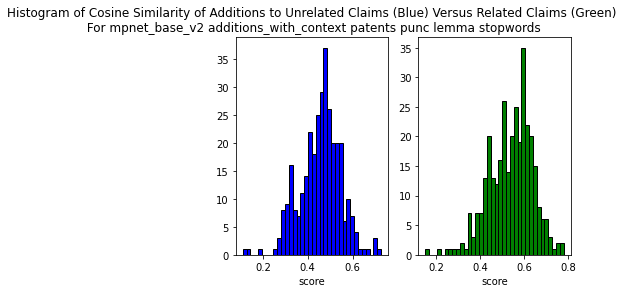

mean noise: 0.45579511036092757
std_dev noise: 0.0910754339193455
mean related: 0.5374017669302316
std_dev related: 0.09921972630182309
z_score: 0.8960336839193447
p(-z): 0.8148826132953133


In [ ]:
def scoring_method_bert_with_preprocessing(additions, claims, model):
  """ Returns drops list of max cosines scores for each addition to claim, but drops stops word, lemmatize
  """
  additions=preprocess_with_spacy_nlp(additions, ["punc", "lemma", "stopwords"])
  claims=preprocess_with_spacy_nlp(claims, ["punc", "lemma", "stopwords"])
  # Compute embedding for both lists
  additions_embeddings = model.encode(
      additions,
      convert_to_tensor=True,
  )
  claims_embeddings = model.encode(
      claims,
      convert_to_tensor=True,
  )
  # Compute cosine-similarity for every additions to every claim
  cosine_scores = util.pytorch_cos_sim(
      additions_embeddings, claims_embeddings
  ).tolist()
  # return the highest similarity score for each section to patent claim
  return [max(x) for x in cosine_scores]
model_mpnet_base_v2 = SentenceTransformer("stsb-mpnet-base-v2", device=_device)
model_mpnet_base_v2.zero_grad()
# Will limit size since CUDA runs out of memory
model_mpnet_base_v2.max_seq_length=512
mpnet_base_v2_punc_lemma_stop=calculate_score(random_NDA_list, "additions_with_context", "patents", scoring_method_bert_with_preprocessing, model_mpnet_base_v2, silent=True)
model_mpnet_base_v2.zero_grad()
plot_print(mpnet_base_v2_punc_lemma_stop, "mpnet_base_v2 additions_with_context patents punc lemma stopwords")

In [14]:
def plot2(score_list_set, model, method="Cosine Similarity"):
  fig,ax=plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True)
  fig.suptitle(f"Histogram of {method} of Additions to Unrelated Claims (Blue) Versus Related Claims (Green)\n For {model}")
  ax[0].hist(score_list_set[0], color="blue", edgecolor="black", bins=int(180/5))
  ax[1].hist(score_list_set[1], color="green", edgecolor="black", bins=int(180/5))
  ax[1].set_xlabel('score')
  display(fig)
  plt.close()



The following presents the historgram plots shown above in a more viewer friendly manner.

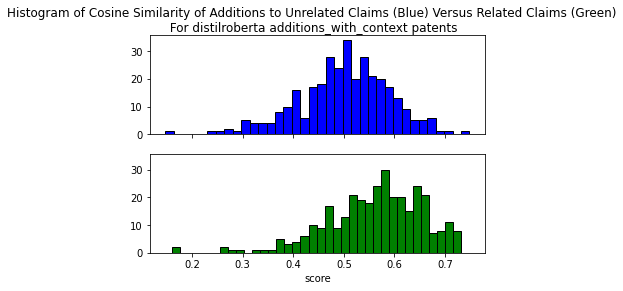

mean noise: 0.5004733486838759
std_dev noise: 0.08934526989761629
mean related: 0.5607847069655073
std_dev related: 0.09567025792291695
z_score: 0.675036947683343
p(-z): 0.7501738544484114


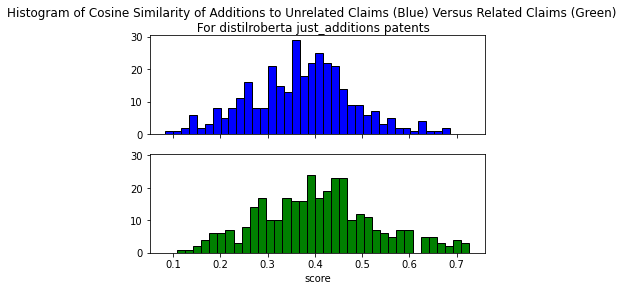

mean noise: 0.3716139454943803
std_dev noise: 0.10965992463432835
mean related: 0.4068881264547623
std_dev related: 0.12442657411102401
z_score: 0.3216688419037963
p(-z): 0.6261482075867304


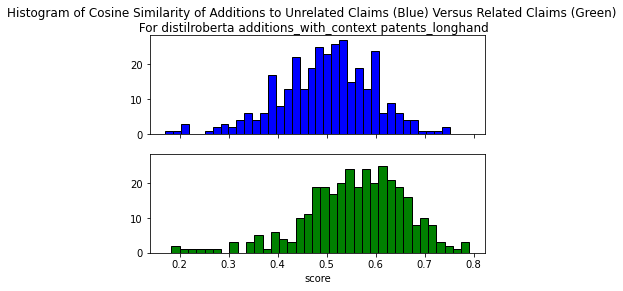

mean noise: 0.49805954747556075
std_dev noise: 0.09670328486955583
mean related: 0.5581885474989585
std_dev related: 0.10342180240966864
z_score: 0.6217885990585167
p(-z): 0.732959558003027


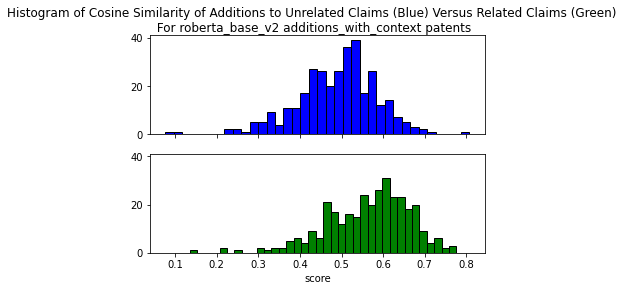

mean noise: 0.4885933166749539
std_dev noise: 0.09712029532671895
mean related: 0.5643114832822393
std_dev related: 0.10063484810581934
z_score: 0.7796327879004549
p(-z): 0.7821964745699855


In [ ]:
plot_print(distilroberta_additions_with_context_patents, "distilroberta additions_with_context patents", plot_=plot2)
plot_print(distilroberta_just_additions_patents, "distilroberta just_additions patents", plot_=plot2)
plot_print(distilroberta_additions_with_context_patents_longhand, "distilroberta additions_with_context patents_longhand", plot_=plot2)
plot_print(roberta_base_v2, "roberta_base_v2 additions_with_context patents", plot_=plot2)

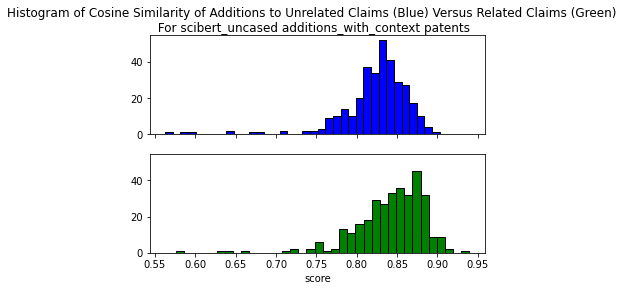

mean noise: 0.8231999282974127
std_dev noise: 0.042995305679390125
mean related: 0.8419258896454255
std_dev related: 0.043767350022005144
z_score: 0.4355350206752703
p(-z): 0.6684129376186183


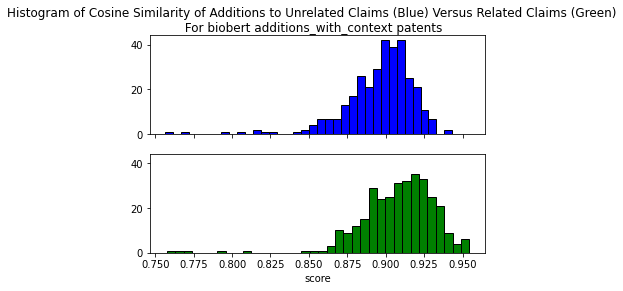

mean noise: 0.895509648809786
std_dev noise: 0.023633738224793546
mean related: 0.9074018180359154
std_dev related: 0.025882182529893112
z_score: 0.5031861279420272
p(-z): 0.6925832915377483


In [ ]:
plot_print(scibert_uncased, "scibert_uncased additions_with_context patents", plot_=plot2)
plot_print(biobert, "biobert additions_with_context patents", plot_=plot2)

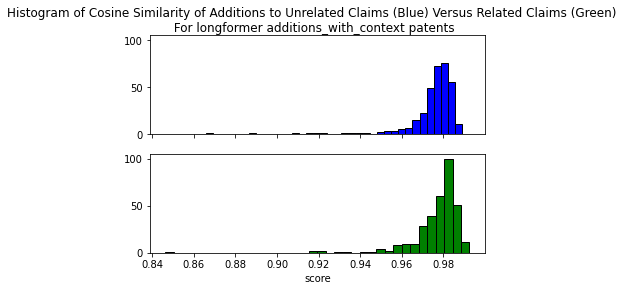

mean noise: 0.9750181277683894
std_dev noise: 0.012870070837641715
mean related: 0.976726786080129
std_dev related: 0.01313463779470629
z_score: 0.13276215285017803
p(-z): 0.5528092565092222


In [ ]:
plot_print(longformer, "longformer additions_with_context patents", plot_=plot2)

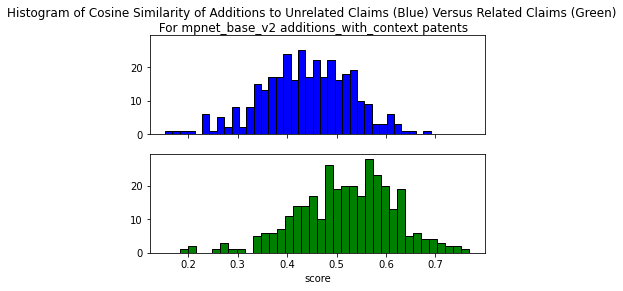

mean noise: 0.4379976573072343
std_dev noise: 0.09040082803374878
mean related: 0.5194639898788157
std_dev related: 0.09819081536804886
z_score: 0.9011679908636246
p(-z): 0.8162504964332901


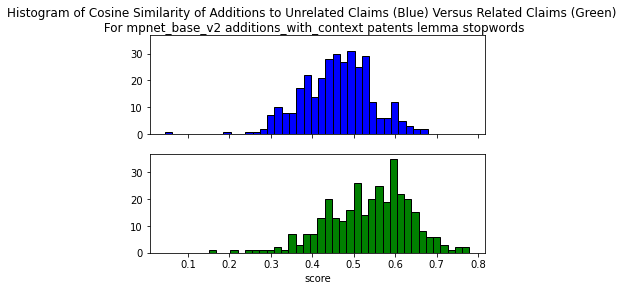

mean noise: 0.4594119418956195
std_dev noise: 0.08517038962857619
mean related: 0.5374017669302316
std_dev related: 0.09921972630182309
z_score: 0.9156917723955682
p(-z): 0.8200857092151411


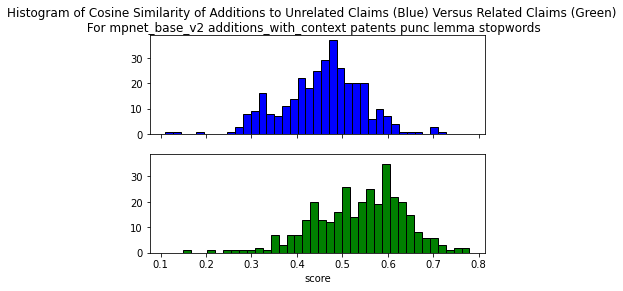

mean noise: 0.45579511036092757
std_dev noise: 0.0910754339193455
mean related: 0.5374017669302316
std_dev related: 0.09921972630182309
z_score: 0.8960336839193447
p(-z): 0.8148826132953133


In [ ]:
plot_print(mpnet_base_v2, "mpnet_base_v2 additions_with_context patents", plot_=plot2)
plot_print(mpnet_base_v2_lemma_stop, "mpnet_base_v2 additions_with_context patents lemma stopwords", plot_=plot2)
plot_print(mpnet_base_v2_punc_lemma_stop, "mpnet_base_v2 additions_with_context patents punc lemma stopwords", plot_=plot2)

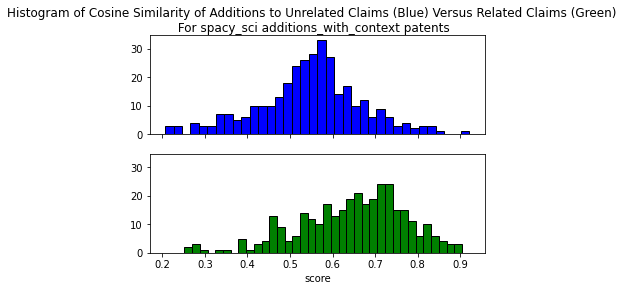

mean noise: 0.5462093602761117
std_dev noise: 0.12192011209500322
mean related: 0.6461000895553783
std_dev related: 0.125938847744988
z_score: 0.8193129711152931
p(-z): 0.7936960630465137


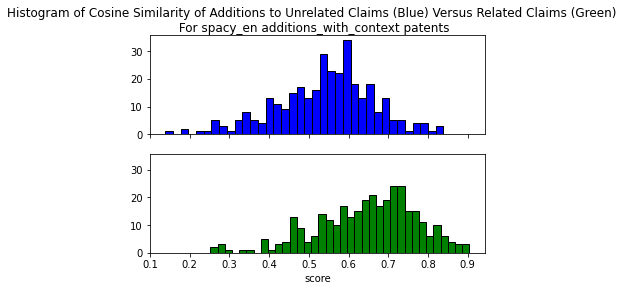

mean noise: 0.5406748139009613
std_dev noise: 0.12172848580239802
mean related: 0.6461000895553783
std_dev related: 0.125938847744988
z_score: 0.8660690631242552
p(-z): 0.8067738552879775


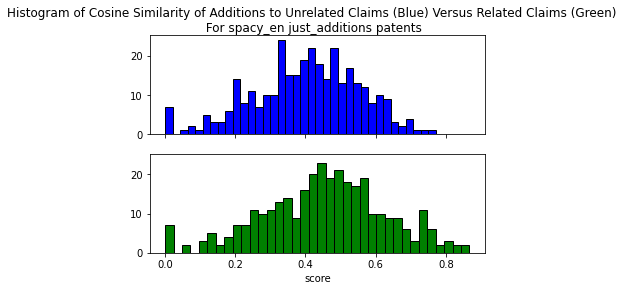

mean noise: 0.40163483769551805
std_dev noise: 0.151589300125265
mean related: 0.45337575025235166
std_dev related: 0.1749808859311617
z_score: 0.3413229859500491
p(-z): 0.6335697772438462


In [ ]:
plot_print(spacy_sci, "spacy_sci additions_with_context patents", plot_=plot2)
plot_print(spacy_en, "spacy_en additions_with_context patents", plot_=plot2)
plot_print(spacy_en_just_additions, "spacy_en just_additions patents", plot_=plot2)

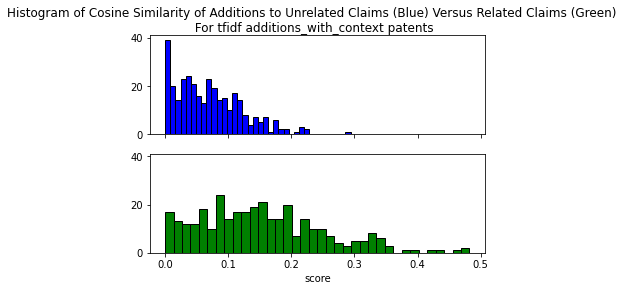

mean noise: 0.06916472691861368
std_dev noise: 0.05316396484580964
mean related: 0.15244918564885993
std_dev related: 0.09820197005072008
z_score: 1.5665584568757138
p(-z): 0.9413910326749335


In [ ]:
plot_print(tfidf, "tfidf additions_with_context patents", plot_=plot2)

The following reruns multi_mpnet_base_v2, which has among the highest z-score from the noise distribution, 4 more times with a different sample of random NDAs to confirm general performance of mpnet_base_v2.

mpnet_base_v2 is a prime candidate for the NLP engine, since its has a relatively high z-score from the noise model, but also since it works well without lots of preprocessing steps.  Furthermore the variance of mpnet_base_v2 distribution is smaller.  A smaller variance indicates that the mpnet_base_v2 is more consistent.  ScispaCy also has a high z-score, but it's distribution variance is higher too, which is less desirable.

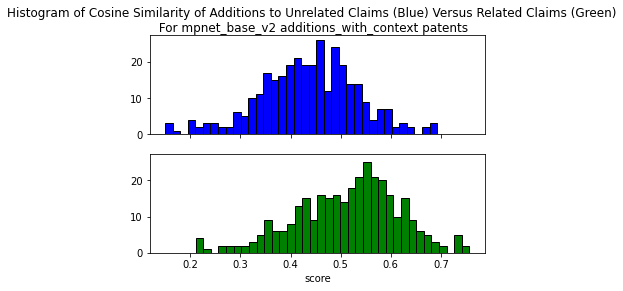

mean noise: 0.4357152694025543
std_dev noise: 0.09793141495534204
mean related: 0.5128176093099469
std_dev related: 0.1043688993042962
z_score: 0.7873095670327266
p(-z): 0.7844496647075425


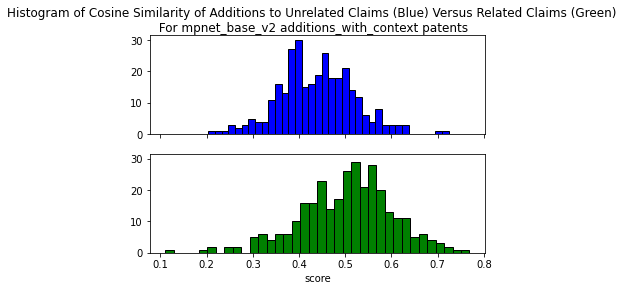

mean noise: 0.4385414431258353
std_dev noise: 0.08158853843906748
mean related: 0.5022791339842002
std_dev related: 0.10266879432453961
z_score: 0.7812088815142327
p(-z): 0.7826601745530932


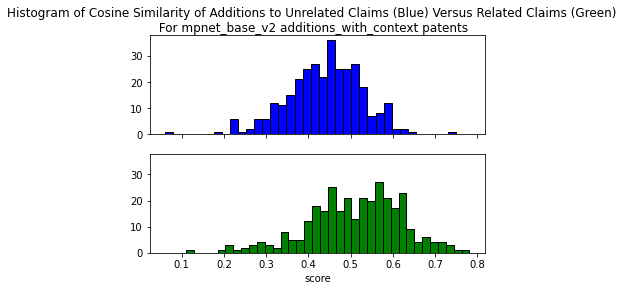

mean noise: 0.43903196955406915
std_dev noise: 0.08812338614058611
mean related: 0.5093673995444097
std_dev related: 0.10987711571677317
z_score: 0.79814715560444
p(-z): 0.7876074503492689


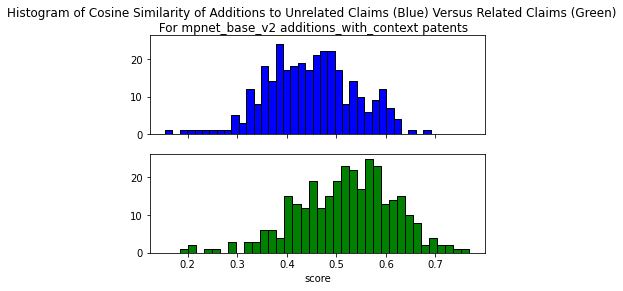

mean noise: 0.44761367654457446
std_dev noise: 0.08842540288405881
mean related: 0.5184398328642416
std_dev related: 0.09793774693171711
z_score: 0.8009706940496792
p(-z): 0.7884256940828424


In [16]:
run_multi_mpnet_base_v2=[]
model_mpnet_base_v2 = SentenceTransformer("stsb-mpnet-base-v2", device=_device)

for i in range(4):
  random_NDA_list=random.sample(NDA_list, int(len(NDA_list)*.33))
  # narrow 1/3 of random data to NDA with patents and NDAs with additions.  If either is missing, we cannot check quality of additions to related patents.
  random_NDA_list=[x for x in random_NDA_list if get_patent_claims(x, 'patents') and get_additions(x, 'additions_with_context')]
  model_mpnet_base_v2.zero_grad()
  # Will limit size since CUDA runs out of memory
  model_mpnet_base_v2.max_seq_length=512
  run_multi_mpnet_base_v2.append(calculate_score(random_NDA_list, "additions_with_context", "patents", scoring_method_bert, model_mpnet_base_v2, silent=True))
  model_mpnet_base_v2.zero_grad()
  plot_print(run_multi_mpnet_base_v2[i], "mpnet_base_v2 additions_with_context patents", plot_=plot2)


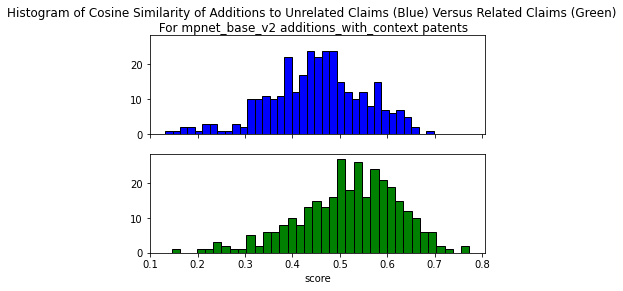

mean noise: 0.45028193419245766
std_dev noise: 0.10201532178139869
mean related: 0.519433811966916
std_dev related: 0.10458023671766596
z_score: 0.6778577626078454
p(-z): 0.751069058674058


In [17]:
model_mpnet_base_v2.zero_grad()
# Will limit size since CUDA runs out of memory
model_mpnet_base_v2.max_seq_length=512
mpnet_base_v2_longhand=calculate_score(random_NDA_list, "additions_with_context", "patents_longhand", scoring_method_bert, model_mpnet_base_v2, silent=True)
model_mpnet_base_v2.zero_grad()
plot_print(mpnet_base_v2_longhand, "mpnet_base_v2 additions_with_context patents", plot_=plot2)